In [1]:
import tfim
import tfim_perturbation
import tfim_matrices
import tfim_rdm
import numpy as np
from scipy import sparse
from scipy.sparse import linalg as spla
from scipy import optimize
import progressbar
import itertools
import matplotlib.pyplot as pl
import matplotlib.ticker as mtick
import schmidt_decomp

In [2]:
# Initial system specification
L = [2,2]
init = 2
final = 11.
num_steps = 20
h_x_range = np.linspace(init, final, num_steps)
PBC = True
J = 1

In [3]:
def Jij_2D_NN(seed, N, PBC, xwidth, yheight, lattice):

    def bond_list(seed, N, PBC, xwidth, yheight):
        np.random.seed(seed)
        # Generates a random list of bonds with equal numbers of ferromagnetic and antiferromagnetic bonds
        if PBC == True:
            num_of_bonds = 2*N
        else:
            num_of_bonds = (xwidth - 1)*(yheight) + (xwidth)*(yheight - 1)
        if num_of_bonds%2 == 0:
            a1 = [-1 for i in range(num_of_bonds//2)]
        else:
            a1 = [-1 for i in range((num_of_bonds//2) + 1)]
        a2 = [1 for i in range(num_of_bonds//2)]
        a = list(np.random.permutation(a1+a2))
        return a

    def make_Jij(N, b_list, lattice):
        #Goes through the list of bonds to make the jij matrix that tells you how all of the spins are bonded to each other

        bond_index = 0
        Jij = np.zeros((N,N))
        for i in range(0,N):
            NNs = lattice.NN(i)
            for j in NNs:
                if Jij[i][j] == 0:
                    Jij[i][j] = b_list[bond_index]
                    Jij[j][i] = b_list[bond_index]
                    bond_index += 1
        return Jij
    
    b_list = bond_list(seed, N, PBC, xwidth, yheight)
    return make_Jij(N, b_list, lattice)

In [4]:
# Build lattice and basis
lattice = tfim.Lattice(L, PBC)
N = lattice.N
basis = tfim.IsingBasis(lattice)

In [5]:
#construct random J matrix
seed = 34
Jij = Jij_2D_NN(82, N, PBC, L[0], L[1], lattice)

In [6]:
# List out all the spin_states, corresponding indices and energies
Energies = -tfim.JZZ_SK_ME(basis,Jij)
for index in range(2**N):
    print(index, basis.state(index), Energies[index])

0 [0 0 0 0] -0.0
1 [0 0 0 1] 1.0
2 [0 0 1 0] 1.0
3 [0 0 1 1] 2.0
4 [0 1 0 0] 1.0
5 [0 1 0 1] -0.0
6 [0 1 1 0] -2.0
7 [0 1 1 1] -3.0
8 [1 0 0 0] -3.0
9 [1 0 0 1] -2.0
10 [1 0 1 0] -0.0
11 [1 0 1 1] 1.0
12 [1 1 0 0] 2.0
13 [1 1 0 1] 1.0
14 [1 1 1 0] 1.0
15 [1 1 1 1] -0.0


In [7]:
GS_energy, GS_indices = tfim_perturbation.GS(Energies)

# initialize Lanczos vector 
v0 = np.zeros(2**N)
for i in GS_indices:
    v0[i] = 1

In [8]:
# modified exact Hamiltonians using compressed sparse row matrices
def V_exact_csr(basis, lattice):
    row = []
    col = []
    for ket in range(basis.M):
        state = basis.state(ket)
        for i in range(lattice.N):
            basis.flip(state,i)
            bra = basis.index(state)
            row.append(bra)
            col.append(ket)
            basis.flip(state,i)
    data = np.ones(len(col))
    V_exact = sparse.csr_matrix((data, (np.array(row), np.array(col))), shape = (2**N, 2**N))
    return V_exact

def H_0_exact_csr(Energies):
    return sparse.diags(Energies)

In [9]:
# modified function to eigendecompose the exact Hamiltonian using Lanczos method
def exc_eigensystem(basis, h_x_range, lattice, Energies):
    # Calculate exact eigenvalues and eigenstates for range(h_x)
    exc_eigenvalues = np.zeros(len(h_x_range))
    first_excited_exc_energies = np.zeros(len(h_x_range))
    exc_eigenstates = np.zeros((len(h_x_range), basis.M))
    V_exc_csr = V_exact_csr(basis, lattice)
    H_0_exc_csr = H_0_exact_csr(Energies)
    for j, h_x in enumerate(h_x_range):
        H = H_0_exc_csr - V_exc_csr.multiply(h_x)
        exc_eigenvalue, exc_eigenstate = spla.eigsh(H, k = 4, v0 = v0, maxiter = 200, return_eigenvectors = True)
        exc_eigenvalues[j] = exc_eigenvalue[0]
        first_excited_exc_energies[j] = exc_eigenvalue[1]
        for k in range(basis.M):
            exc_eigenstates[j][k] = exc_eigenstate[k, 0]
    return V_exc_csr, H_0_exc_csr, exc_eigenvalues, first_excited_exc_energies, exc_eigenstates

In [10]:
# Calculate exact eigenvalues and eigenstates for range(h_x)
V_exc, H_0_exc, exc_eigenvalues, first_excited__exc_energies, exc_eigenstates = exc_eigensystem(basis, h_x_range, lattice, Energies)

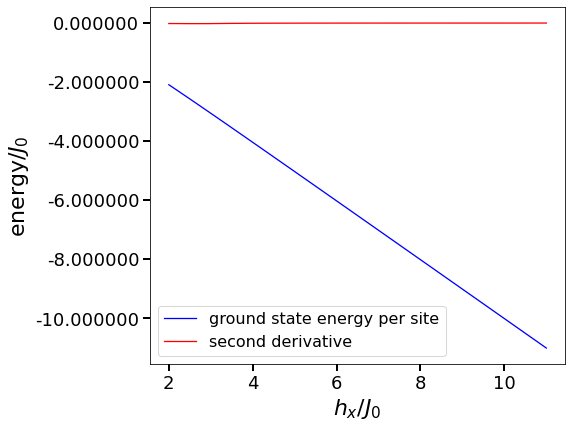

In [13]:
# first and second derivative of ground state energy per site
first_derivative_exc_eigenvalues = np.gradient(exc_eigenvalues, (final-init)/float(num_steps))
second_derivative_exc_eigenvalues = np.gradient(first_derivative_exc_eigenvalues, (final-init)/float(num_steps))

# ground energy plot
fig = pl.figure(figsize=(8, 6))
pl.rcParams['font.size'] = '18'
pl.plot(h_x_range,exc_eigenvalues/float(N), lw=1.3, ls='-', color="blue", label= "ground state energy per site")
pl.plot(h_x_range,second_derivative_exc_eigenvalues/float(N), lw=1.3, ls='-', color="red", label= "second derivative")
pl.ylabel(r'energy$/J_0$', fontsize=22)
pl.xlabel(r'$h_x/J_0$', fontsize=22)
pl.xticks(fontsize=18)
pl.yticks(fontsize=18)
pl.tick_params('both', length=7, width=2, which='major')
pl.tick_params('both', length=5, width=2, which='minor')
pl.gca().yaxis.set_major_formatter(mtick.FormatStrFormatter('%.6f'))
pl.grid(False)
# pl.xscale('log')
pl.legend(loc=0, prop={'size': 16}, numpoints=1, scatterpoints=1, ncol=1)
fig.tight_layout(pad=0.5)

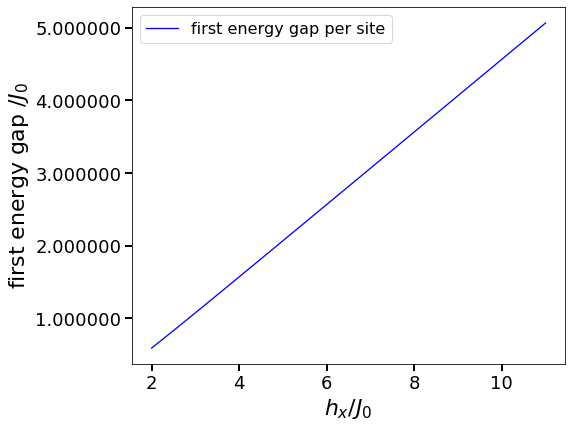

In [14]:
# First energy gap plot
fig = pl.figure(figsize=(8, 6))
pl.rcParams['font.size'] = '18'
pl.plot(h_x_range, (first_excited__exc_energies - exc_eigenvalues)/float(N), lw=1.3, ls='-', color="blue", label= "first energy gap per site")
pl.ylabel(r'first energy gap $/J_0$', fontsize=22)
pl.xlabel(r'$h_x/J_0$', fontsize=22)
pl.xticks(fontsize=18)
pl.yticks(fontsize=18)
pl.tick_params('both', length=7, width=2, which='major')
pl.tick_params('both', length=5, width=2, which='minor')
pl.gca().yaxis.set_major_formatter(mtick.FormatStrFormatter('%.6f'))
pl.grid(False)
# pl.xscale('log')
pl.legend(loc=0, prop={'size': 16}, numpoints=1, scatterpoints=1, ncol=1)
fig.tight_layout(pad=0.5)

In [15]:
# compute susciptibility
h_z = 0.0001

In [16]:
chi_aa_matrix = np.zeros((len(h_x_range), lattice.N))
for i, h_x in enumerate(h_x_range):
    for a in range(lattice.N):
        sigma_z = np.zeros(basis.M)
        for ket in range(basis.M):
            state = basis.state(ket)
            if state[a] == 1:
                sigma_z[ket] += 1
            else:
                sigma_z[ket] -= 1
        longitudinal_energy = spla.eigsh(H_0_exc - V_exc.multiply(h_x) - h_z*sparse.diags(sigma_z), k = 4, which = 'BE', v0 = v0, maxiter = 200, return_eigenvectors = False)[0]
        chi_aa = 2.*abs(abs(exc_eigenvalues[i]) - abs(longitudinal_energy))/(h_z**2)
        chi_aa_matrix[i, a] += chi_aa

In [18]:
chi_ab_matrix = np.zeros((len(h_x_range), basis.N, basis.N))
for i, h_x in enumerate(h_x_range):
    for a in range(lattice.N):
        sigma_z_a = np.zeros(basis.M)
        for ket in range(basis.M):
            state = basis.state(ket)
            if state[a] == 1:
                sigma_z_a[ket] += 1
            else:
                sigma_z_a[ket] -= 1
        for b in range(a, lattice.N, 1):
            sigma_z_b = np.zeros(basis.M)
            for ket in range(basis.M):
                state = basis.state(ket)
                if state[b] == 1:
                    sigma_z_b[ket] += 1
                else:
                    sigma_z_b[ket] -= 1
            H = H_0_exc - V_exc.multiply(h_x) - (sparse.diags(sigma_z_a) + sparse.diags(sigma_z_b)).multiply(h_z)
            longitudinal_energy = spla.eigsh(H, k = 4, which = 'BE', v0 = v0, maxiter = 200, return_eigenvectors = False)[0]
            chi_ab = abs(abs(exc_eigenvalues[i]) - abs(longitudinal_energy))/(h_z**2.) - 0.5*(chi_aa_matrix[i, a] + chi_aa_matrix[i, b])
            chi_ab_matrix[i, a, b] += chi_ab
            chi_ab_matrix[i, b, a] += chi_ab    

chi_arr = np.zeros(len(h_x_range))
for i, h_x in enumerate(h_x_range):
    chi_arr[i] += np.sum(chi_ab_matrix[i])

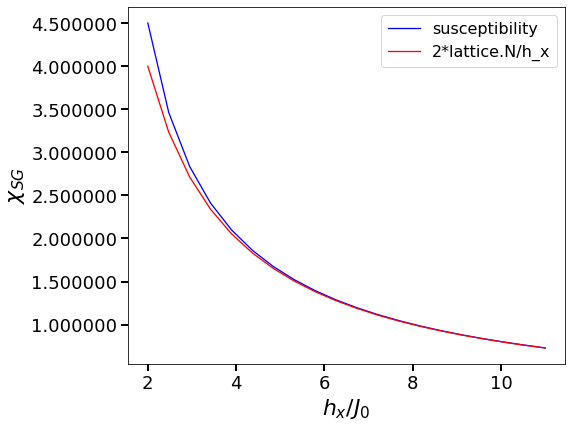

In [19]:
# Susceptibility plot
fig = pl.figure(figsize = (8, 6))
pl.rcParams['font.size'] = '18'
pl.plot(h_x_range, chi_arr, lw = 1.3, ls='-', color="blue", label= "susceptibility")
pl.plot(h_x_range, 2*lattice.N/h_x_range, lw = 1.3, ls='-', color="red", label= "2*lattice.N/h_x")
pl.ylabel(r'$\chi_{SG}$', fontsize=22)
pl.xlabel(r'$h_x/J_0$', fontsize=22)
pl.xticks(fontsize=18)
pl.yticks(fontsize=18)
pl.tick_params('both', length=7, width=2, which='major')
pl.tick_params('both', length=5, width=2, which='minor')
pl.gca().yaxis.set_major_formatter(mtick.FormatStrFormatter('%.6f'))
pl.grid(False)
# pl.xscale('log')
pl.legend(loc=0, prop={'size': 16}, numpoints=1, scatterpoints=1, ncol=1)
fig.tight_layout(pad=0.5)

In [20]:
# compute structure factor
S_SG_arr = np.zeros(np.shape(h_x_range))
for i, h_x in enumerate(h_x_range):
    psi0 = exc_eigenstates[i]
    for a in range(N):
        for b in range(N):
            sigma_z_a = np.zeros(basis.M)
            sigma_z_b = np.zeros(basis.M)
            for ket in range(basis.M):
                state = basis.state(ket)
                if state[a] == 1:
                    sigma_z_a[ket] += 1
                else:
                    sigma_z_a[ket] -= 1
            for ket in range(basis.M):
                state = basis.state(ket)
                if state[b] == 1:
                    sigma_z_b[ket] += 1
                else:
                    sigma_z_b[ket] -= 1
            S_ab = psi0 @ sparse.diags(sigma_z_a) @ sparse.diags(sigma_z_b) @ psi0.T
            S_SG_arr[i] += S_ab**2.

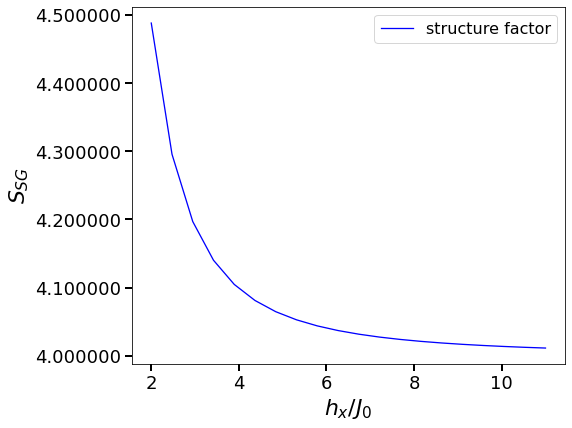

In [21]:
# structure factor plot
fig = pl.figure(figsize = (8, 6))
pl.rcParams['font.size'] = '18'
pl.plot(h_x_range, S_SG_arr, lw = 1.3, ls='-', color="blue", label= "structure factor")
pl.ylabel(r'$S_{SG}$', fontsize=22)
pl.xlabel(r'$h_x/J_0$', fontsize=22)
pl.xticks(fontsize=18)
pl.yticks(fontsize=18)
pl.tick_params('both', length=7, width=2, which='major')
pl.tick_params('both', length=5, width=2, which='minor')
pl.gca().yaxis.set_major_formatter(mtick.FormatStrFormatter('%.6f'))
pl.grid(False)
# pl.xscale('log')
pl.legend(loc=0, prop={'size': 16}, numpoints=1, scatterpoints=1, ncol=1)
fig.tight_layout(pad=0.5)

In [22]:
# h_x_range runs from 2 to 10 for 10 values
